Data Description

Variable | Definition

record_ID           | Unique ID for each week store sku combination

week                  | Starting Date of the week

store_id              | Unique ID for each store (no 

numerical order to be assumed)

sku_id                | Unique ID for each product (no 
numerical order to be assumed)

total_price        | Sales Price of the product

base_price       | Base price of the product

is_featured_sku | Was part of the featured item of the week

is_display_sku   | Product was on display at a prominent place at the store

units_sold          | (Target) Total Units sold for that week-store-sku combination

IMPORT LIBRARY

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from numpy import sqrt, abs, round
from scipy.stats import t as t_dist
from scipy.stats import t
from numpy import sqrt, abs, round
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings(action = 'ignore')

In [200]:
!pip install --upgrade category_encoders

In [201]:
train_df = pd.read_csv('/content/train_0irEZ2H.csv')
test_df = pd.read_csv('/content/test_nfaJ3J5.csv')

In [202]:
train_df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [203]:
test_df.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


TYPECASTING

In [204]:
print('There are', '\033[1m', train_df.shape[0], '\033[0m', 'observations in the dataset and',
      '\033[1m', train_df.shape[1], '\033[0m','variables, where one refers to the ID and 9 independent \nvariables and 1 target variable (units_Sold)')

There are  150150  observations in the dataset and  9  variables, where one refers to the ID and 9 independent 
variables and 1 target variable (units_Sold)


In [205]:
(train_df.isnull().sum()/train_df.shape[0])*100

record_ID          0.000000
week               0.000000
store_id           0.000000
sku_id             0.000000
total_price        0.000666
base_price         0.000000
is_featured_sku    0.000000
is_display_sku     0.000000
units_sold         0.000000
dtype: float64

In [206]:
train_df[train_df['sku_id'].isnull()]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold


In [207]:
train_df = train_df.dropna()

In [208]:
test_df.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
dtype: int64

In [209]:
train_df.dtypes

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

In [210]:
train_df['Other_Charges'] = train_df['total_price'] - train_df['base_price']
test_df['Other_Charges'] = test_df['total_price'] - test_df['base_price']

In [211]:
test_df['units_sold'] = -1
data = train_df.append(test_df, ignore_index = True)

In [212]:
numerical = data.select_dtypes(include=['int64','float64'])

PERFORMING UNIVARIATE ANALYSIS

In [213]:
def uva(data,vargroup):
  size = len(vargroup)
  plt.figure(figsize = (10*size,5), dpi = 125)
  for j,i in enumerate(vargroup):
    max = data[i].max()
    min = data[i].min()
    range = [max,min]
    skew = data[i].skew()
    kurtosis = data[i].kurtosis()
    mean = data[i].mean()
    median = data[i].median()
    std = data[i].std()
    point = mean-std, mean+std
    plt.subplot(1,size,j+1)
    sns.lineplot(point,[0,0],color='black',label='Standard Devistion')
    sns.kdeplot(data[i],shade=True)
    sns.scatterplot(mean,[0],color='yellow',label='mean')
    sns.scatterplot(median,[0],color='green',label='median')
    sns.scatterplot(range,[0,0],color='brown',label='min/max')
    plt.title('Skew={},Kurtosis={},variance={}\nmean={},median={}\nStandard Deviation={}'.format(round(skew,2),round(kurtosis,2),round(std**2,2),round(mean,2),median,round(std,2)))

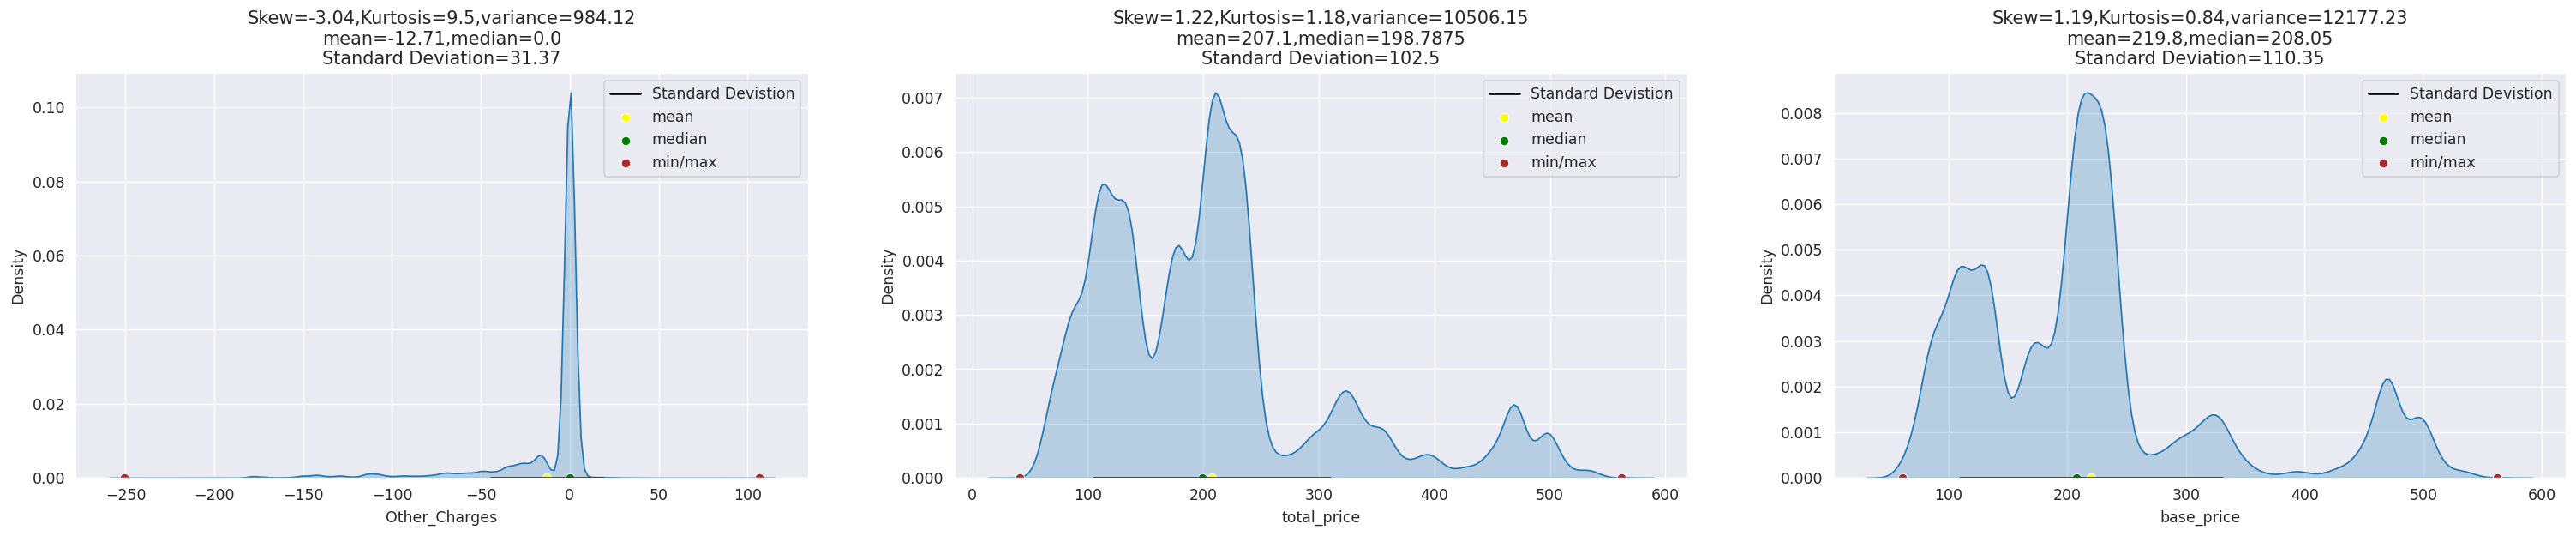

In [214]:
uva(numerical,['Other_Charges','total_price','base_price'])

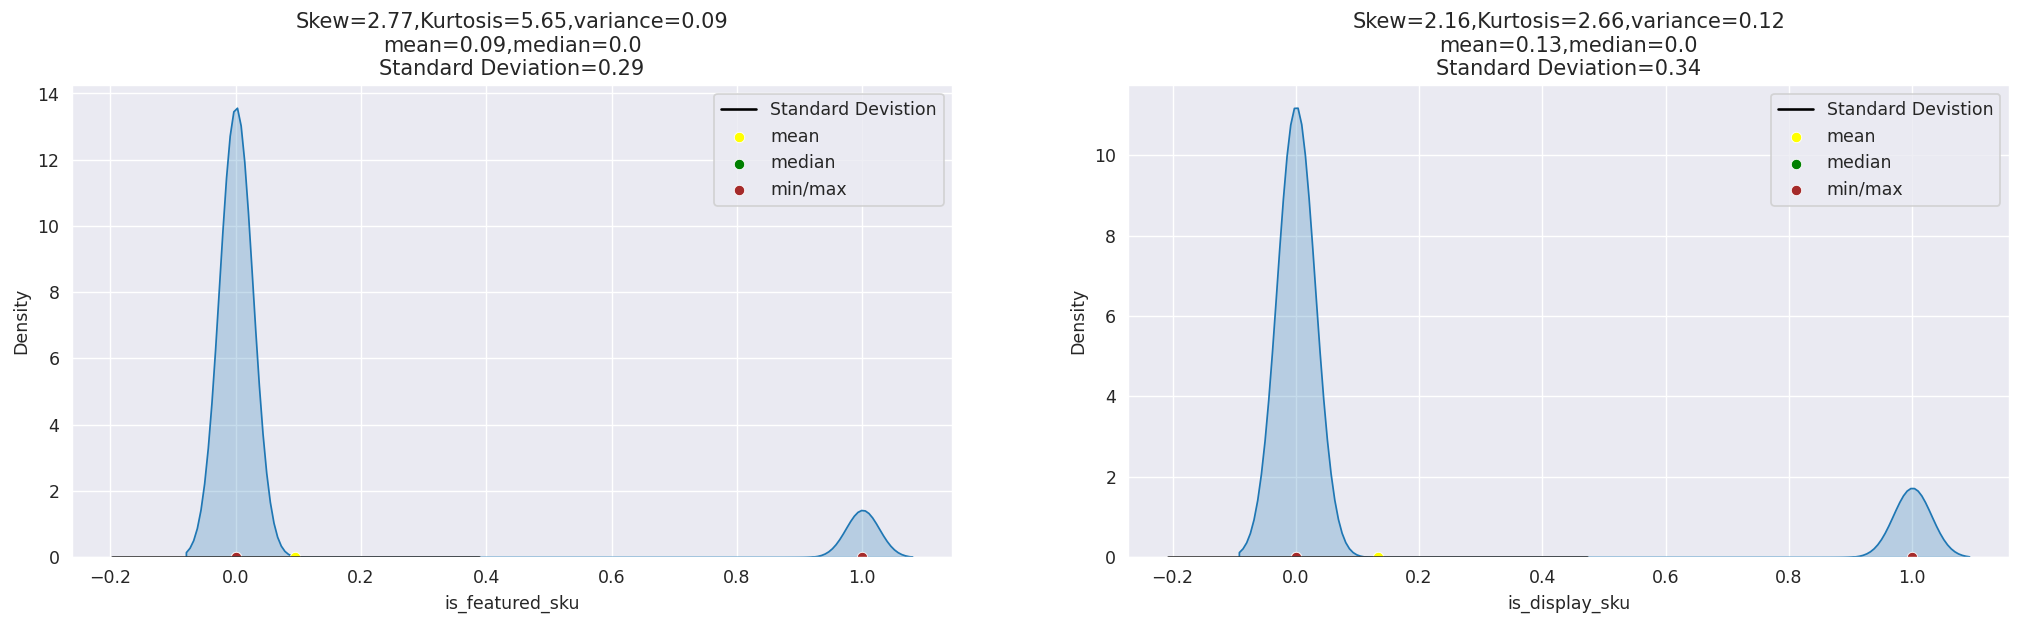

In [215]:
uva(numerical,['is_featured_sku','is_display_sku'])

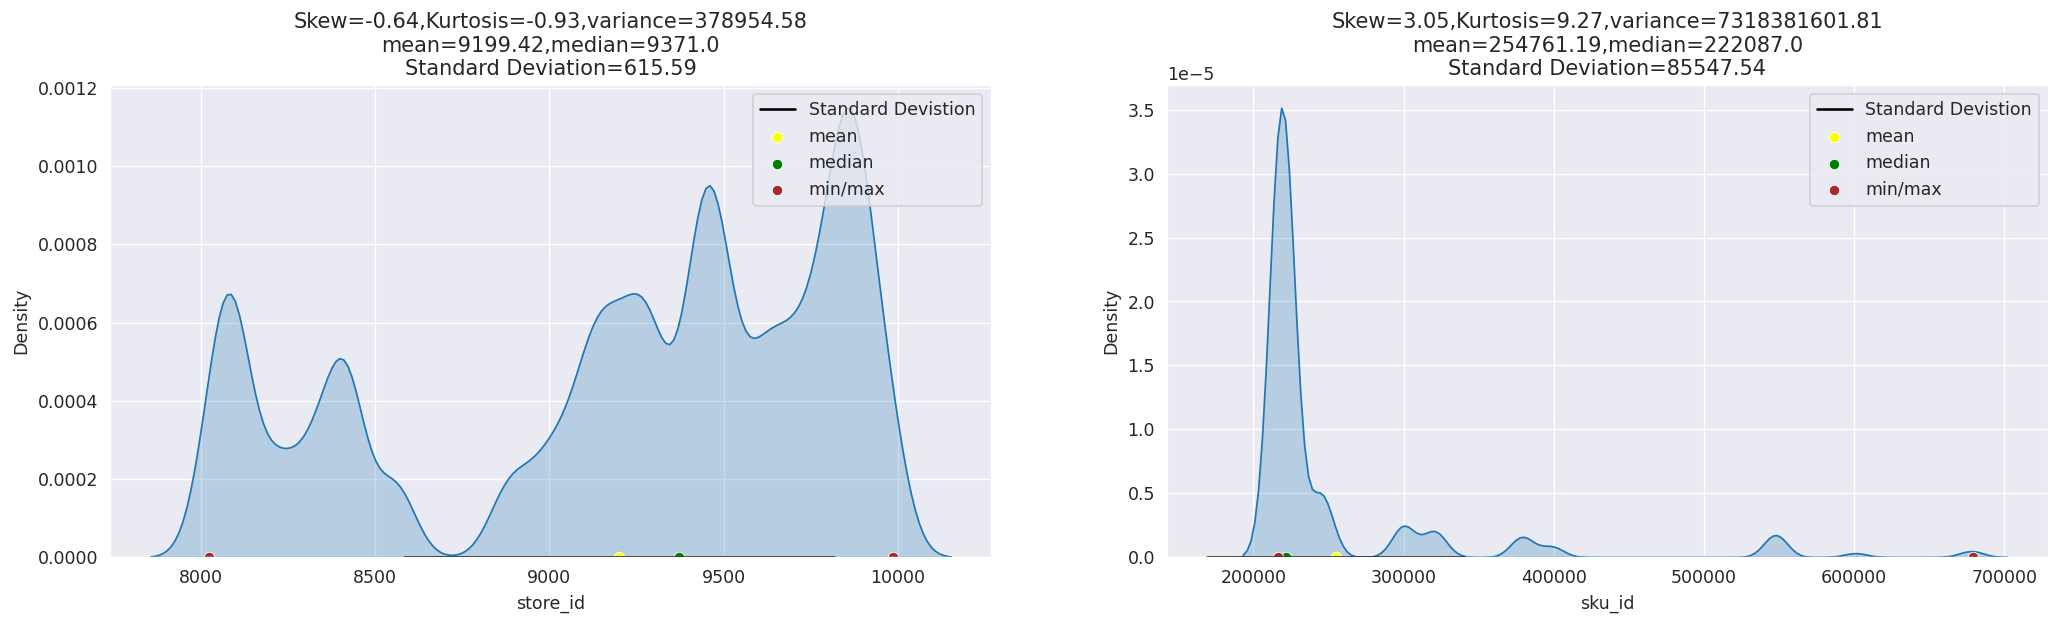

In [216]:
uva(numerical,['store_id','sku_id'])

OBSERVATION
From Univariate Analysis we see that is_featured_sku,is_display_sku is Nominal Variables, while total_price,base_price are numerical and are distributed unevenly with base_price have huge number between 0-250.
Base_price and total_price are almost identical in terms of distribution

In [217]:
def boxplot_numeric(data,vargroup,include_outlier=True):
  size = len(vargroup)
  plt.figure(figsize = (7*size,4), dpi = 100)
  for j,i in enumerate(vargroup):
    min = data[i].min()
    max = data[i].max()
    q1 = data[i].quantile(0.25)
    q3 = data[i].quantile(0.75)
    iqr = q3-q1
    left_whisker = q1-(1.5*iqr)
    right_whisker = q3+(1.5*iqr)
    median = data[i].median()
    skew = data[i].skew()
    kurtosis = data[i].kurtosis()
    outlier_max = len(data[data[i]>right_whisker])
    outlier_min = len(data[data[i]<left_whisker])
    plt.subplot(1,size,(j+1))
    sns.boxplot(data[i])
    plt.title('Q1={},Q3={},IQR={}\nmedian={},skew={}\nKurtosis={},Outliers(max/min)={}'.format(round(q1,2),round(q3,2),round(iqr,2),median,round(skew,2),round(kurtosis,2),(outlier_max,outlier_min)))

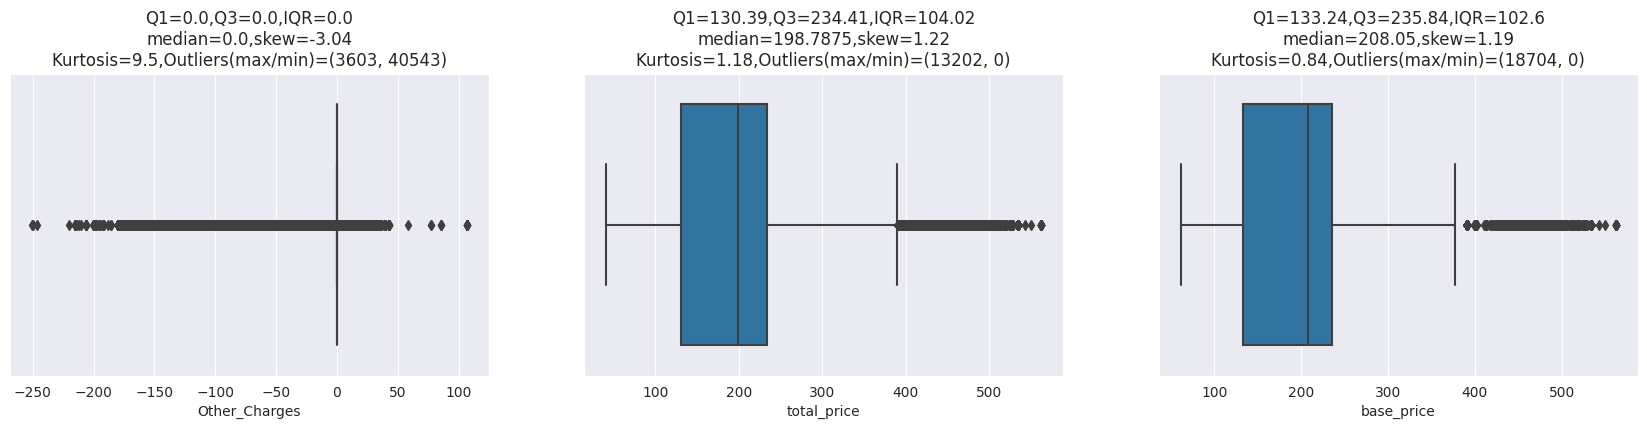

In [218]:
boxplot_numeric(numerical,['Other_Charges','total_price','base_price'])

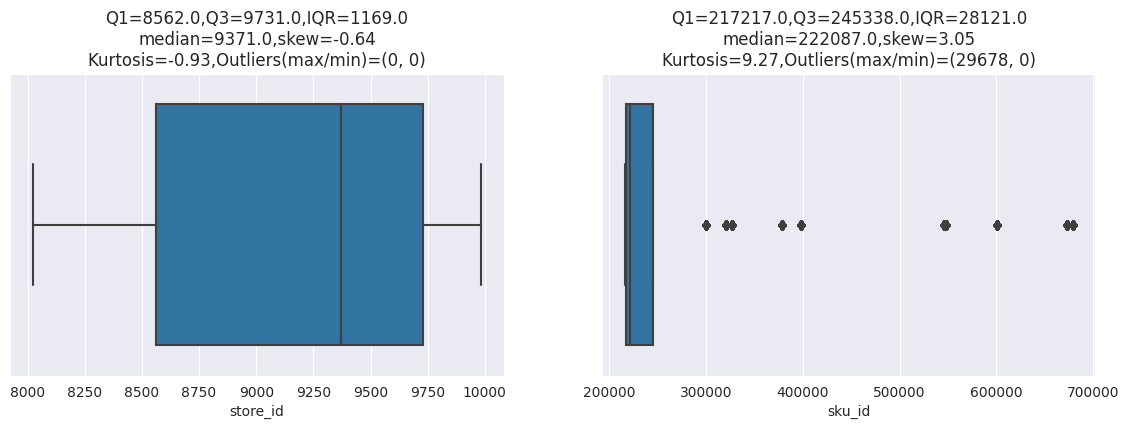

In [219]:
boxplot_numeric(numerical,['store_id','sku_id'])

OBSERVATION:

total_price, base_price have outliers from 400-550 towards Q3.

In [220]:
data['total_price_cat'] = 'str'
data['total_price_cat'][(data['total_price']<= 200)] = 'Low Cost Product'
data['total_price_cat'][((data['total_price']> 200) & (data['total_price']<= 400))] = 'Moderate Cost Product'
data['total_price_cat'][(data['total_price']>400)] = 'High Cost Product'
data['total_price_cat'] = data['total_price_cat'].astype('category')

In [221]:
data['Other_Charges_cat'] = 'str'
data['Other_Charges_cat'][(data['Other_Charges']<= 0)] = 'High Discounted Product'
data['Other_Charges_cat'][(data['Other_Charges']>0)] = 'Less Discounted Product'
data['Other_Charges_cat'] = data['Other_Charges_cat'].astype('category')


In [222]:
data['is_featured_sku_cat'] = 'str'
data['is_featured_sku_cat'][(data['is_featured_sku']<= 0)] = 'Not_Featured_Item'
data['is_featured_sku_cat'][(data['is_featured_sku']>0)] = 'Featured_Item'
data['is_featured_sku_cat'] = data['is_featured_sku_cat'].astype('category')

In [223]:
data['is_display_sku_cat'] = 'str'
data['is_display_sku_cat'][(data['is_display_sku']<= 0)] = 'Not_Displayed_Item'
data['is_display_sku_cat'][(data['is_display_sku']>0)] = 'Displayed_Item'
data['is_display_sku_cat'] = data['is_display_sku_cat'].astype('category')

UNIVARIATE CATEGORICAL ANALYSIS

In [149]:
def UVA_category(data, var_group):
    
    size = len(var_group)
    plt.figure(figsize = (7*size,7), dpi = 100)
    
    for j,i in enumerate(var_group):
        norm_count = round(data[i].value_counts(normalize = True)*100,2)
        n_uni = data[i].nunique()
        sns.set_style('darkgrid')
        plt.subplot(1,size,j+1)
        sns.barplot(norm_count, norm_count.index , order = norm_count.index)
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel('{}'.format(i), fontsize = 20)
        plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

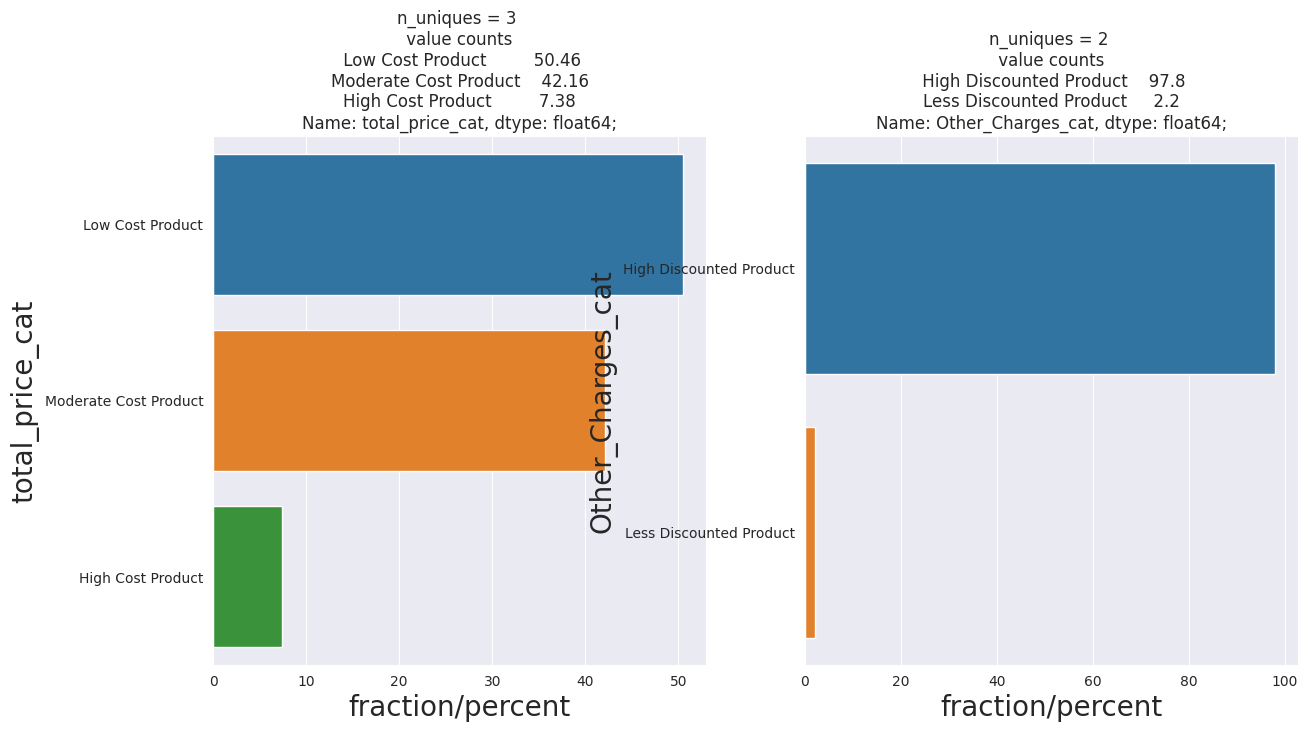

In [150]:
UVA_category(data,['total_price_cat','Other_Charges_cat'])

OBSERVATION

Approx 50% of products lies in range low cost product which is in range 0-200 and approx 42% of products lies in the range 200-400.

More than 97% of products have additional charges from base_charge and rest 3% of products have same charge as base_price from total_price.

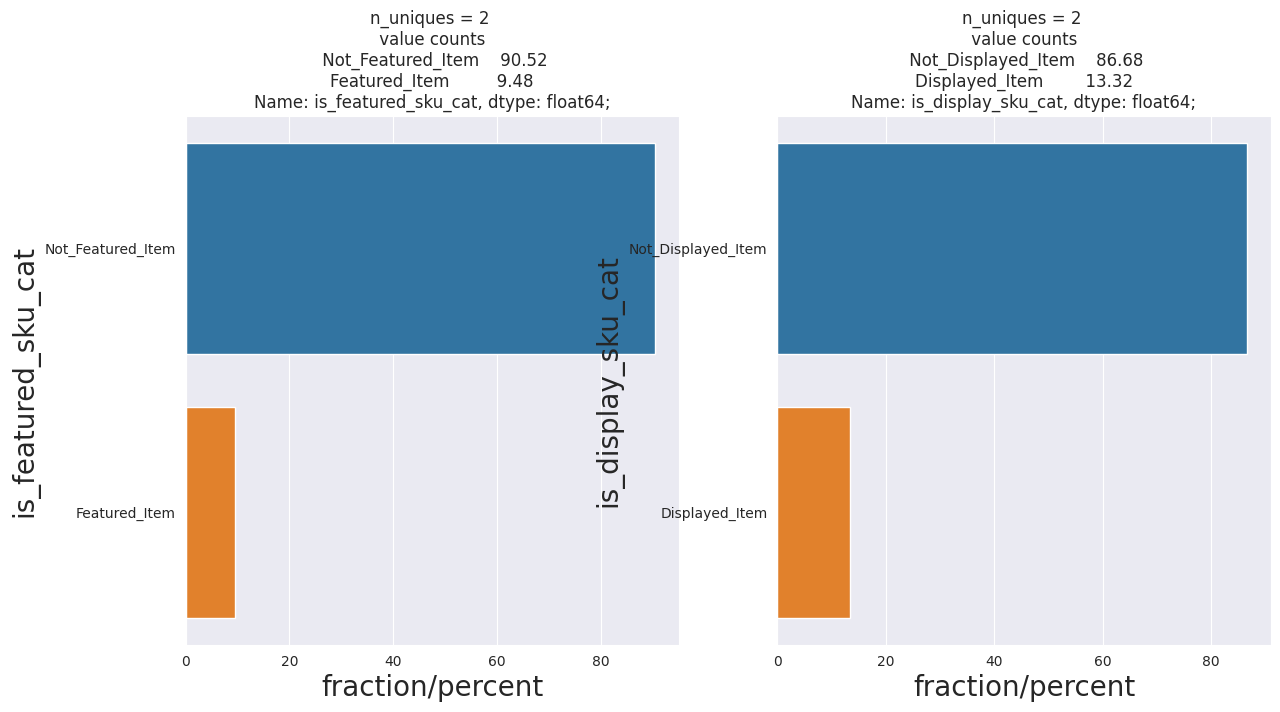

In [151]:
UVA_category(data,['is_featured_sku_cat','is_display_sku_cat'])

OBSERVATION:

Approx 90% of products is not featured item in that week while 10% of the products is featured item in that week.

Approx 86% of products is not displayed item in that week while 14% of products is displayed item in that week.

BIVARIATE ANALYSIS

NUMERICAL-NUMERICAL

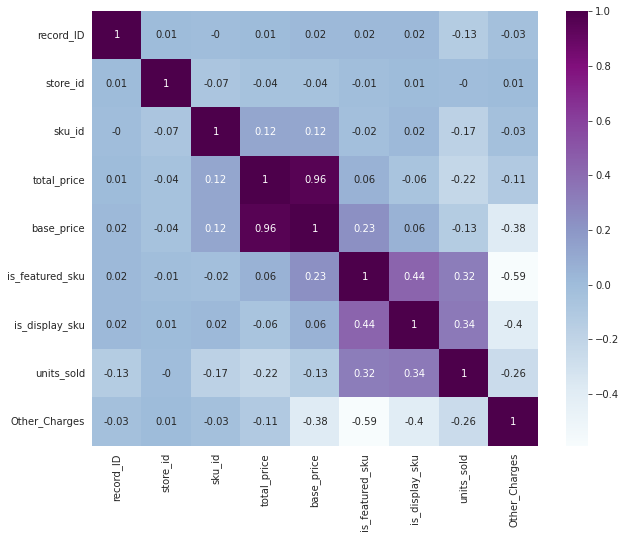

In [152]:
rounded = round(numerical.corr(method = 'pearson'),2)
plt.figure(figsize=(10,8))
ax = sns.heatmap(rounded, cmap='BuPu', annot=True)
plt.show()

OBSERVATION:

*   is_featured_sku,is_display sku is highly correlated.
*   base_price and total_price is highly correlated.
*   sku_id and total_price are also correlated

<Figure size 840x560 with 0 Axes>

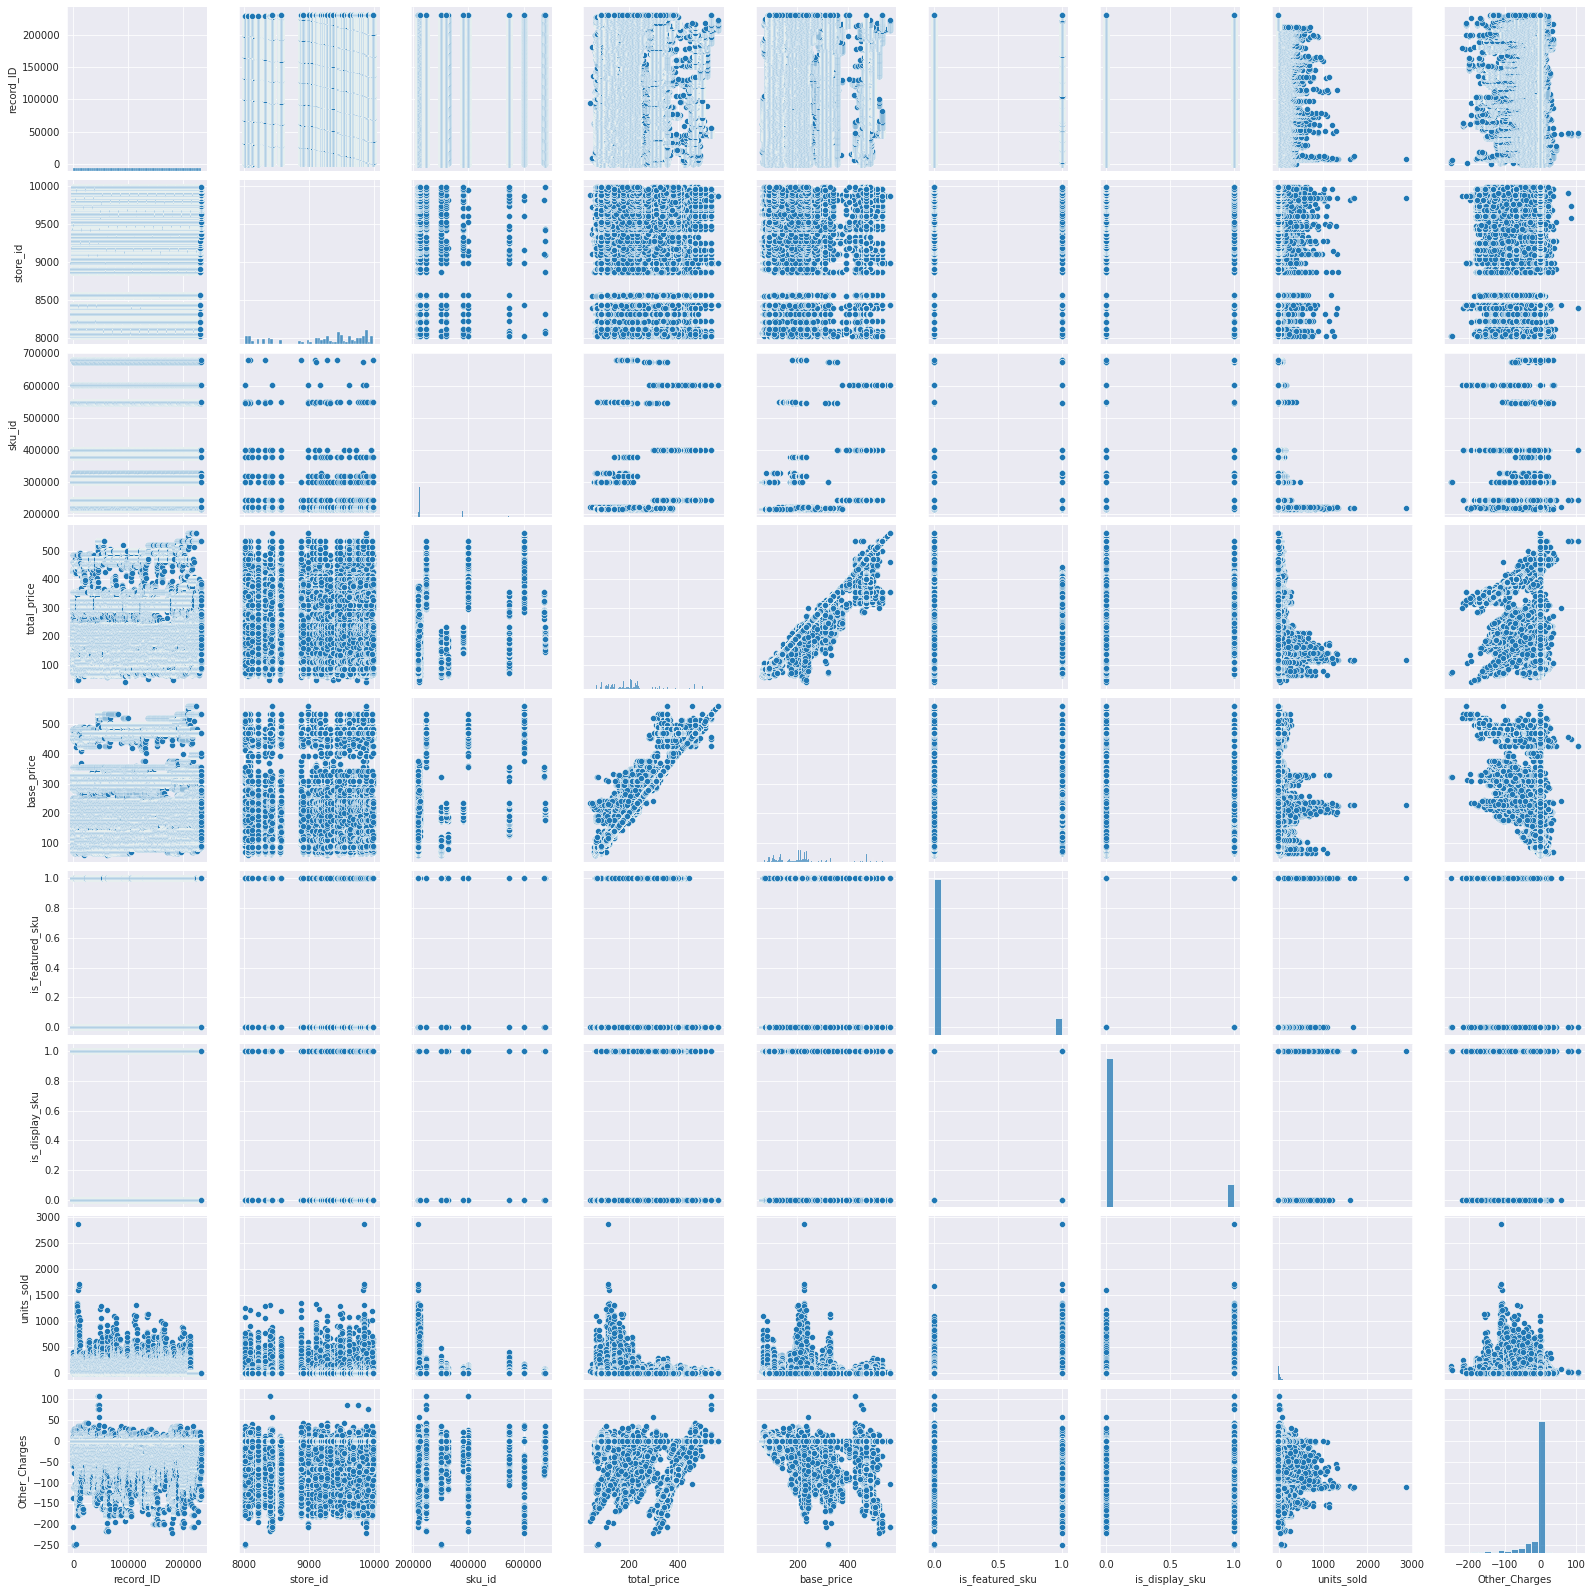

In [153]:
plt.figure(dpi=140)
sns.pairplot(data = numerical)

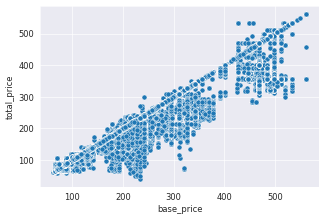

In [154]:
plt.figure(dpi=60)
sns.scatterplot(numerical['base_price'], numerical['total_price'])

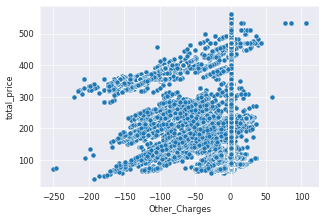

In [155]:
plt.figure(dpi=60)
sns.scatterplot(numerical['Other_Charges'], numerical['total_price'])

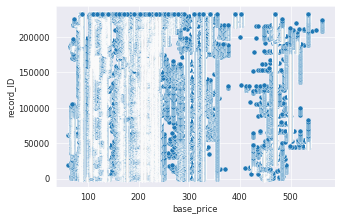

In [156]:
plt.figure(dpi=60)
sns.scatterplot(numerical['base_price'], numerical['record_ID'])

In [72]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['total_price_cat']= label_encoder.fit_transform(data['total_price_cat'])
data['is_featured_sku_cat']= label_encoder.fit_transform(data['is_featured_sku_cat'])
data['is_display_sku_cat']= label_encoder.fit_transform(data['is_display_sku_cat'])
data['Other_Charges_cat']= label_encoder.fit_transform(data['Other_Charges_cat'])

In [67]:
cols = ['base_price','Other_Charges','total_price','is_featured_sku','is_display_sku']

BIVARIATE ANALYSIS CATEGORICAL-NUMERICAL

HYPOTHESIS TESTING
*   Does is_display_item and is_featured_item have a significant impact on the units_sold?
*   Does is_display_item and is_featured_item have a significant impact on the base_price?
*   Does is_display_item and is_featured_item have a significant impact on the total_price?
*   Does is_display_item and is_featured_item have a significant impact on the store_id?

In [69]:
def TwoSampZ(X1, X2, sigma1, sigma2, N1, N2):
    over = (sigma1**2/N1) + (sigma2**2/N2)
    ovr_sigma = sqrt(over)
    z = (X1 - X2)/ovr_sigma
    pval = 2*(1 - norm.cdf(abs(z)))
    return pval
'''''
Testing if they are equal or not. If p_value < 0.05 we reject the null hypothesis
'''''

def TwoSampT(X1, X2, sd1, sd2, n1, n2):
  ovr_sd = sqrt(sd1**2/n1 + sd2**2/n2)
  t = (X1 - X2)/ovr_sd
  df = n1+n2-2
  pval = 2*(1 - t_dist.cdf(abs(t),df))
  return pval
'''''
Testing if they are equal or not. If p_value < 0.05 we reject the null hypothesis
'''''

def Bivariate_cont_cat(data, cont, cat, category):
  x1 = data[cont][data[cat]==data[category]][:]
  x2 = data[cont][~(data[cat]==data[category])][:]
  n1, n2 = x1.shape[0], x2.shape[0]
  m1, m2 = x1.mean(), x2.mean()
  std1, std2 = x1.std(), x2.mean()
  t_p_val = round(TwoSampT(m1, m2, std1, std2, n1, n2),4)
  z_p_val = round(TwoSampZ(m1, m2, std1, std2, n1, n2),4)
  table = pd.pivot_table(data=data, values=cont, columns=cat, aggfunc = np.mean)
  table = round(table,2)
  plt.figure(figsize = (15,6), dpi=140)
  plt.subplot(1,4,1)
  sns.barplot([str(category),'not {}'.format(category)], [m1, m2])
  plt.ylabel('mean {}'.format(cont))
  plt.xlabel(cat)
  plt.title('n {}'.format(table))
  plt.subplot(1,4,2)
  sns.boxplot(x=cat, y=cont, data=data)
  plt.title('categorical boxplot')
  plt.subplot(1,4,3)
  x_min = -200
  x_max = 200
  x = np.linspace(x_min, x_max, 100)
  y = norm.pdf(x, m2, std2)
  plt.xlim(x_min, x_max)
  plt.plot(x, y)
  confidence_level = 0.95
  alpha = 1 - confidence_level
  z_critical = norm.ppf(1 - alpha)
  z_critical_left = m2 + (-z_critical * std2)
  z_critical_right = m2 + (z_critical * std2)
  x1 = np.linspace(x_min, z_critical_left, 100)
  y1 = norm.pdf(x1, m2, std2)
  plt.fill_between(x1, y1, color='green')
  x2 = np.linspace(z_critical_right, x_max, 100)
  y2 = norm.pdf(x2, m2, std2)
  plt.fill_between(x2, y2, color='green') 
  plt.scatter(m1, 0)
  plt.annotate("x_bar", (m1, 0.0007))
  plt.title('Z-Test \n p-value={}'.format(z_p_val))
    
    
  plt.subplot(1,4,4)
  x_min = -200
  x_max = 200
  x = np.linspace(x_min, x_max, 100)
  y = norm.pdf(x, m2, std2)
  plt.xlim(x_min, x_max)
  plt.plot(x, y)
  confidence_level = 0.95
  alpha = 1 - confidence_level
  t_critical =t.ppf(1-alpha/2,df=9)
  t_critical_left = m2 + (-t_critical * std2)
  t_critical_right = m2 + (t_critical * std2)
  x1 = np.linspace(x_min, t_critical_left, 100)
  y1 = norm.pdf(x1, m2, std2)
  plt.fill_between(x1, y1, color='orange')
  x2 = np.linspace(t_critical_right, x_max, 100)
  y2 = norm.pdf(x2, m2, std2)
  plt.fill_between(x2, y2, color='orange') 
  plt.scatter(m1, 0)
  plt.annotate("x_bar", (m1, 0.0007))
  plt.title('T-Test \n p-value={}'.format(t_p_val))

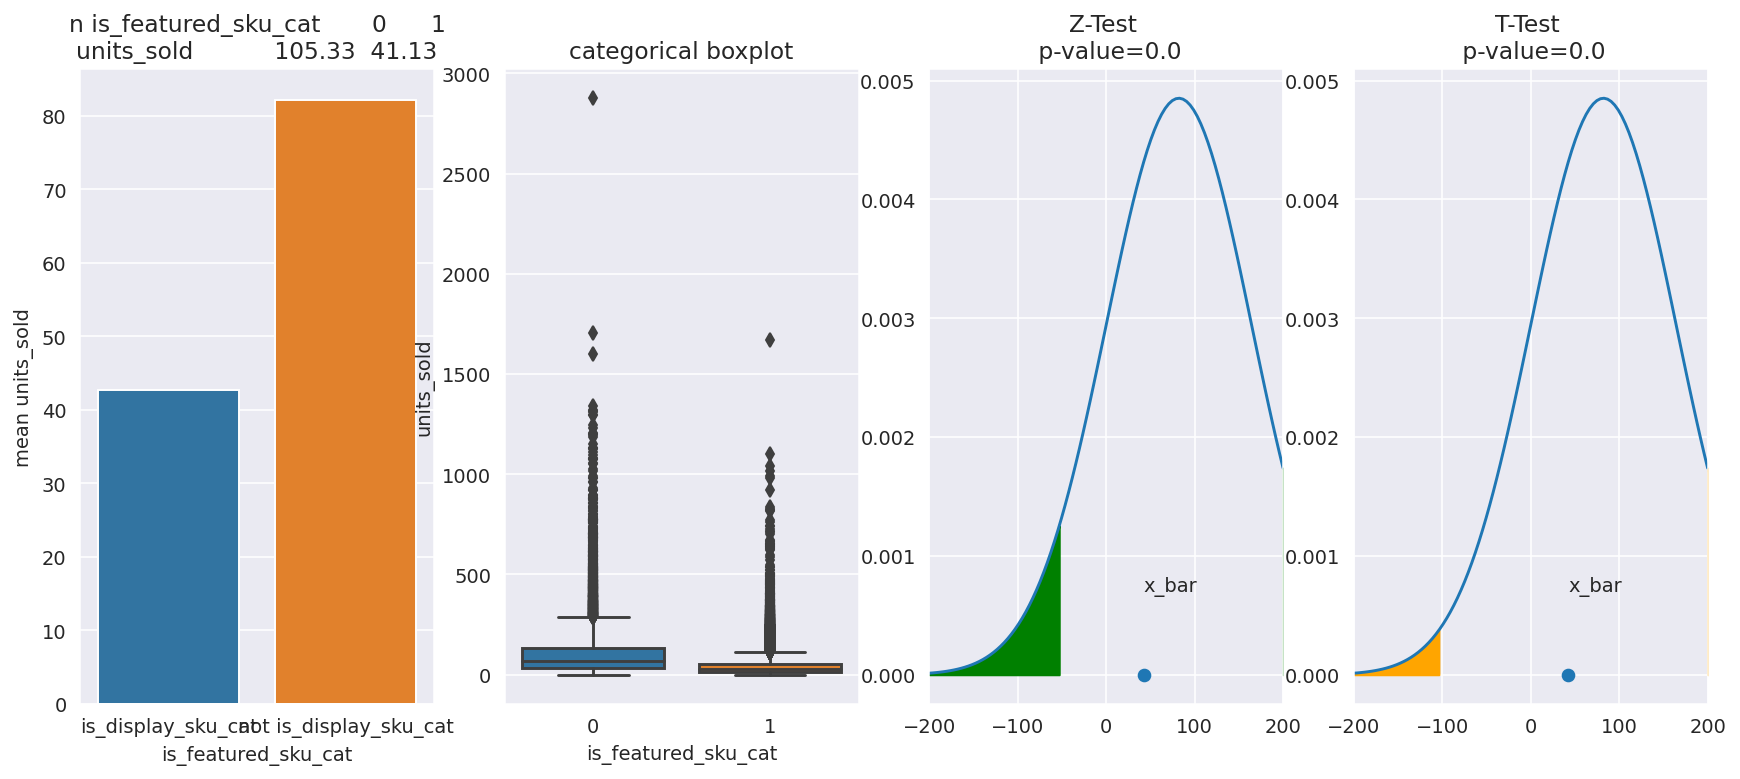

In [75]:
Bivariate_cont_cat(data, 'units_sold', 'is_featured_sku_cat', 'is_display_sku_cat')

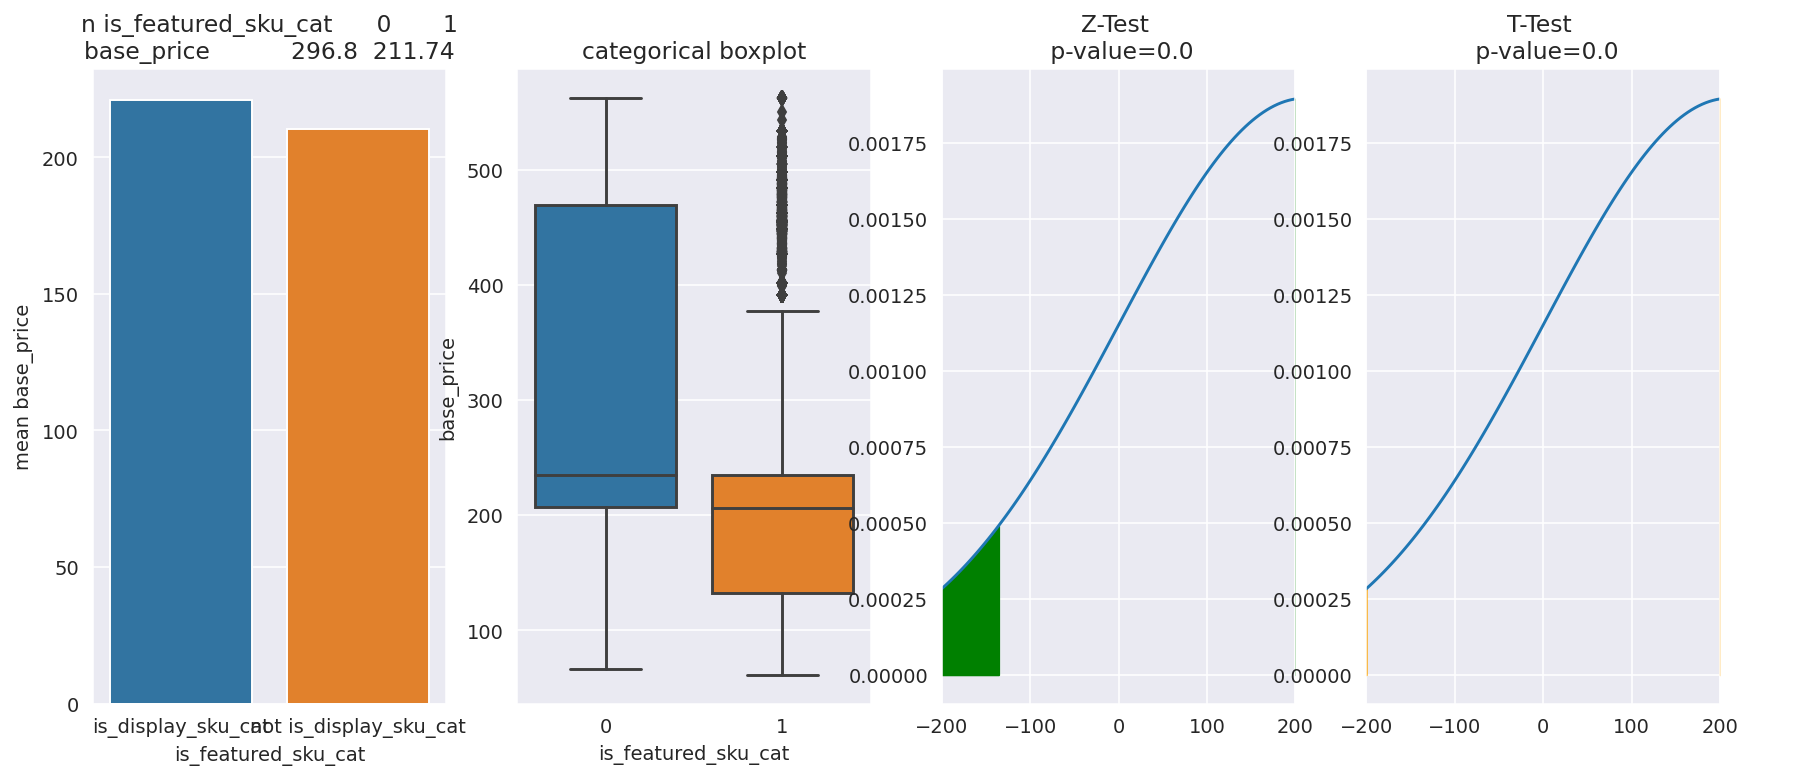

In [76]:
Bivariate_cont_cat(data, 'base_price', 'is_featured_sku_cat', 'is_display_sku_cat')

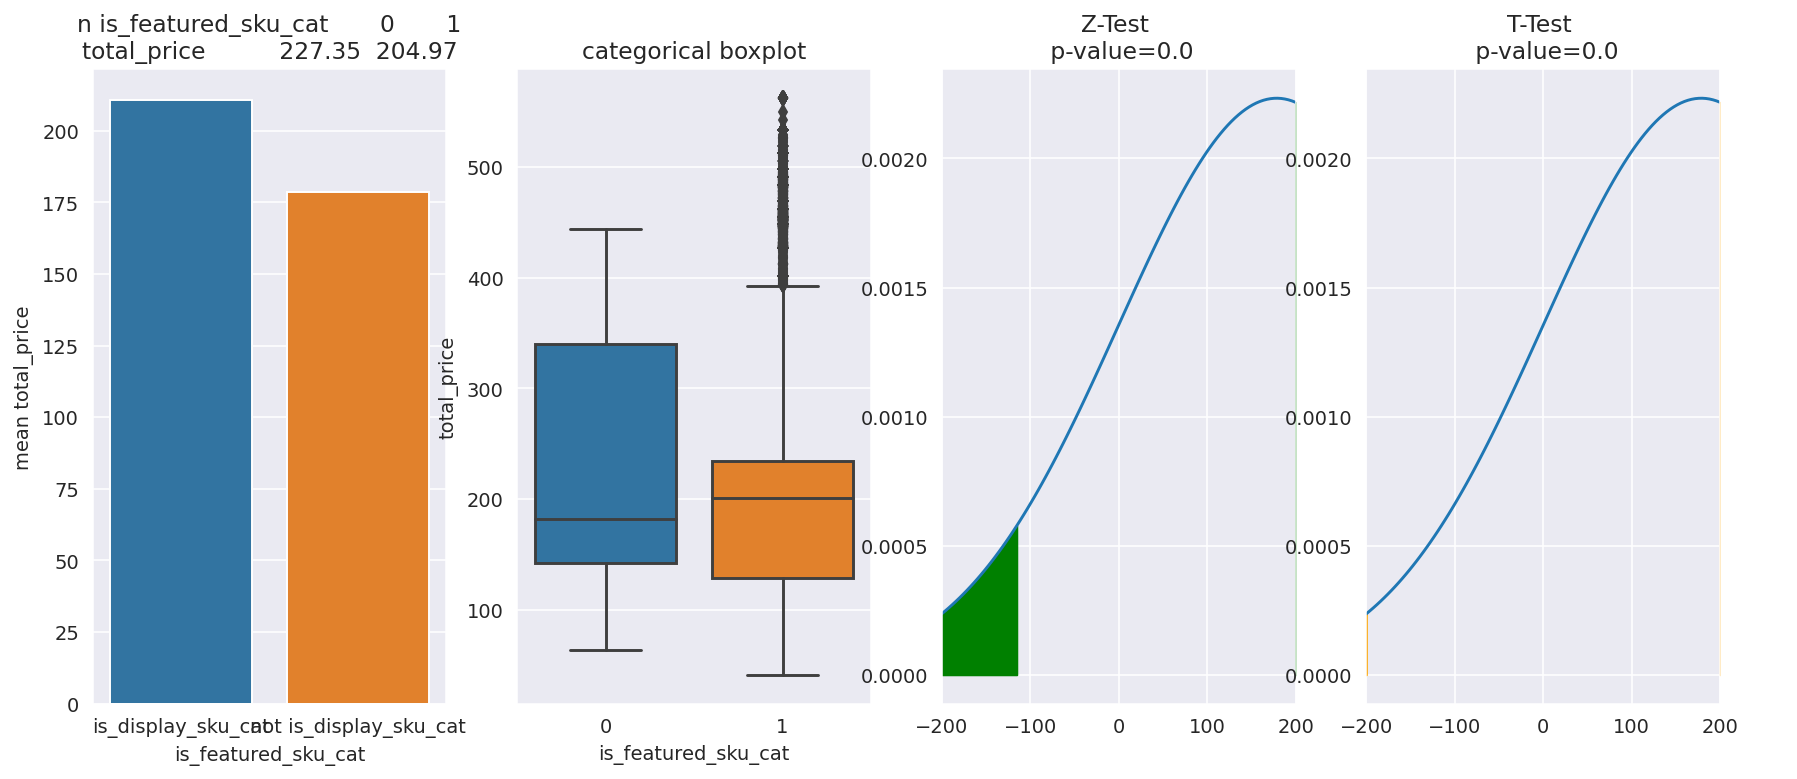

In [77]:
Bivariate_cont_cat(data, 'total_price', 'is_featured_sku_cat', 'is_display_sku_cat')

In [78]:
Bivariate_cont_cat(data, 'store_id', 'is_featured_sku_cat', 'is_display_sku_cat')

MULTIVARIATE ANALYSIS

In [116]:
round(data.pivot_table('units_sold', 'is_featured_sku_cat', 'is_display_sku_cat', aggfunc='mean')*100,3)

is_display_sku_cat,Displayed_Item,Not_Displayed_Item
is_featured_sku_cat,,
Featured_Item,12079.099,8303.014
Not_Featured_Item,8182.491,3734.022


In [117]:
round(data.pivot_table('units_sold', 'total_price_cat', 'is_display_sku_cat', aggfunc='mean')*100,3)

is_display_sku_cat,Displayed_Item,Not_Displayed_Item
total_price_cat,,
High Cost Product,2242.375,1510.974
Low Cost Product,12466.117,4909.425
Moderate Cost Product,4980.081,3313.660


In [122]:
round(data.pivot_table('units_sold', 'Other_Charges_cat', 'is_display_sku_cat', aggfunc='mean')*100,3)

is_display_sku_cat,Displayed_Item,Not_Displayed_Item
Other_Charges_cat,,
High Discounted Product,10002.604,3936.729
Less Discounted Product,8799.818,4891.694


In [121]:
round(data.pivot_table('units_sold', 'Other_Charges_cat', 'is_featured_sku_cat', aggfunc='mean')*100,3)

is_featured_sku_cat,Featured_Item,Not_Featured_Item
Other_Charges_cat,,
High Discounted Product,10675.667,4008.622
Less Discounted Product,5282.767,8885.271


In [183]:
round(data.pivot_table('units_sold', 'total_price_cat', 'is_display_sku_cat', aggfunc='mean')*100,3)

is_display_sku_cat,Displayed_Item,Not_Displayed_Item
total_price_cat,,
High Cost Product,2242.375,1510.974
Low Cost Product,12466.117,4909.425
Moderate Cost Product,4980.081,3313.660


RMSLE

In [224]:
def RMSLE(actual, predicted):

    predicted = np.array([np.log(np.abs(x+1.0)) for x in predicted])
    actual = np.array([np.log(np.abs(x+1.0)) for x in actual])
    log_err = actual-predicted
    
    return 1000*np.sqrt(np.mean(log_err**2))

TRAIN-TEST SPLIT

In [225]:
X = train_df[cols]
y = np.log1p(train_df['units_sold'])
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape)

(120119, 5) (120119,) (30030, 5) (30030,)


BUILDING BASELINE MODEL

In [226]:
lr = LR()
lr.fit(Xtrain, ytrain)
preds = lr.predict(Xval)
print(f'baseline model RMSLE value is: {RMSLE(np.exp(yval), np.exp(preds))}')

baseline model RMSLE value is: 711.5195226317254


PERFORMING ENCODING

In [227]:
from category_encoders import TargetEncoder, MEstimateEncoder
encoder = MEstimateEncoder()
encoder.fit(train_df['store_id'], train_df['units_sold'])
train_df['store_encoded'] = encoder.transform(train_df['store_id'], train_df['units_sold'])
test_df['store_encoded'] = encoder.transform(test_df['store_id'], test_df['units_sold'])

In [228]:
encoder.fit(train_df['sku_id'], train_df['units_sold'])
train_df['sku_encoded'] = encoder.transform(train_df['sku_id'], train_df['units_sold'])
test_df['sku_encoded'] = encoder.transform(test_df['sku_id'], test_df['units_sold'])

In [229]:
test_preds = test_df.copy()

In [230]:
def sku_model(sku, cols_to_use, reg):
    X = train_df[train_df['sku_id'] == sku][cols_to_use]
    y = train_df[train_df['sku_id'] == sku]['units_sold']
    
    Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
    lr.fit(X,np.log1p(y))
    
    y_pred = reg.predict(Xval)
    err = RMSLE(yval, np.exp(y_pred))
    print(f'RMSLE for {sku} is: {err}')
    
    preds = reg.predict(test_df[test_df['sku_id'] == sku][cols_to_use])    
    temp_df =  pd.DataFrame.from_dict({'record_ID': test_preds[test_preds['sku_id'] == sku]['record_ID'],
                                       'units_sold':  np.exp(preds)})
    return err, temp_df

In [231]:
cols_to_use = cols + ['store_encoded', 'sku_encoded']

In [232]:
skus = train_df.sku_id.unique()

TESTING RMSLE BASED ON ENCODED VALUES ON SKU_ID

In [233]:
err = dict()
sub = pd.DataFrame(None, columns = ['record_ID', 'units_sold'])

for sku in skus:
    err[sku], temp = sku_model(sku, cols_to_use, lr)
    sub = sub.append(temp)

print(np.mean(list(err.values())))

RMSLE for 216418 is: 684.36653519586
RMSLE for 216419 is: 613.2117695912125
RMSLE for 216425 is: 712.7425604349005
RMSLE for 216233 is: 555.9980605862924
RMSLE for 217390 is: 738.413410193735
RMSLE for 219009 is: 535.9912689755839
RMSLE for 219029 is: 528.1938538309245
RMSLE for 223245 is: 582.9157795112526
RMSLE for 223153 is: 572.3394247410572
RMSLE for 300021 is: 621.8342989868595
RMSLE for 219844 is: 547.5383803552336
RMSLE for 222087 is: 624.6751733990976
RMSLE for 320485 is: 622.0670266662954
RMSLE for 378934 is: 589.1731493164663
RMSLE for 222765 is: 673.004611973467
RMSLE for 245387 is: 564.6943554712493
RMSLE for 245338 is: 595.9401955284653
RMSLE for 547934 is: 641.110109289448
RMSLE for 300291 is: 685.7626716410049
RMSLE for 217217 is: 586.3493027122705
RMSLE for 217777 is: 561.3067913489308
RMSLE for 398721 is: 561.1203776732907
RMSLE for 679023 is: 641.3880112774776
RMSLE for 546789 is: 575.4495191375466
RMSLE for 600934 is: 485.013514308086
RMSLE for 545621 is: 324.961673

In [234]:
from datetime import datetime
train_df['week'] = train_df['week'].astype('str')
train_df['week'] = [datetime.strptime(x, '%d/%m/%y') for x in train_df['week']]
test_df['week'] = test_df['week'].astype('str')
test_df['week'] = [datetime.strptime(x, '%d/%m/%y') for x in test_df['week']]

In [236]:
import datetime
train_df['weekend_date'] = [x + datetime.timedelta(days=6) for x in train_df['week']]
test_df['weekend_date'] = [x + datetime.timedelta(days=6) for x in test_df['week']]

In [237]:
current_cols = list(train_df.columns)

In [238]:
import datetime 
def extract_time_features(df):
    
    start_date = datetime.datetime(2011,1, 17)
    df['year'] = df['week'].dt.year
    df['date'] = [x.day for x in df['week']]
    df['month'] = df['week'].dt.month
    df['weekday'] = df['week'].dt.dayofweek
    df['weeknum'] = df['week'].dt.weekofyear
    df['week_serial']  = [divmod((x-start_date).total_seconds(), 86400)[0]/7 for x in df['week']]
    df['end_year'] = df['weekend_date'].dt.year
    df['end_date'] = [x.day for x in df['weekend_date']]
    df['end_month'] = df['weekend_date'].dt.month
    df['end_weekday'] = df['weekend_date'].dt.dayofweek
    df['end_weeknum'] = df['weekend_date'].dt.weekofyear
    df['end_week_serial']  = [divmod((x-start_date).total_seconds(), 86400)[0]/7 for x in df['weekend_date']]
    return df

In [239]:
train_df = extract_time_features(train_df)

In [240]:
test_df = extract_time_features(test_df)

In [241]:
def Diff(li1, li2): 
    return list(set(li1) - set(li2))

total_cols = list(test_df.columns)
new_feat = Diff(total_cols, current_cols)
cols_to_use += new_feat


In [242]:
for sku in skus:
    err[sku], temp = sku_model(sku, cols_to_use, lr)
    sub = sub.append(temp)

print(np.mean(list(err.values())))

RMSLE for 216418 is: 675.6898669300672
RMSLE for 216419 is: 599.9652110550726
RMSLE for 216425 is: 707.8491423055431
RMSLE for 216233 is: 553.5672310086585
RMSLE for 217390 is: 734.616281033314
RMSLE for 219009 is: 529.4929696435711
RMSLE for 219029 is: 520.1118131905608
RMSLE for 223245 is: 578.6790357129081
RMSLE for 223153 is: 559.0632843541031
RMSLE for 300021 is: 607.0781795128089
RMSLE for 219844 is: 529.8075618198188
RMSLE for 222087 is: 622.0765236112866
RMSLE for 320485 is: 617.1763816734351
RMSLE for 378934 is: 580.4707423980414
RMSLE for 222765 is: 670.5790295249144
RMSLE for 245387 is: 550.5040175319745
RMSLE for 245338 is: 581.9789338074935
RMSLE for 547934 is: 633.6062501215779
RMSLE for 300291 is: 678.3394084138565
RMSLE for 217217 is: 585.1515151864479
RMSLE for 217777 is: 552.4774403571276
RMSLE for 398721 is: 548.413045874664
RMSLE for 679023 is: 642.0863089021526
RMSLE for 546789 is: 559.4590659661429
RMSLE for 600934 is: 474.8269746307483
RMSLE for 545621 is: 320.10